# Design Project 1: Control Moment Gyroscope – Harry Zhao

Import libraries

In [1]:
import time
import numpy as np
from scipy import linalg
import sympy as sym
import matplotlib.pyplot as plt
import ae353_cmg

## Linearize Model

The dynamic model is represented by matrix `f` and linearized to make matrices `A` and `B`. These matrices are printed. This way, the system can be expressed in the following state-space form.

$$\dot{x}=Ax+Bu$$

In [2]:
q1, q2, t2, v1, v2 = sym.symbols('q1, q2, t2, v1, v2')

# Chosen constant values
q2 = 0.
t3 = 0.
v3 = 10. * np.pi / 3.

# Equilibrium values
q1_e = np.pi / 4.
q2_e = 0.
t2_e = 0.
v1_e = 0.
v2_e = 0.

f = sym.Matrix([[v1],
                [-(5. * (200. * t3 * sym.sin(q2) + sym.sin(2. * q2) * v1 * v2 + 2. * sym.cos(q2) * v2 * v3)) / (10. * sym.sin(q2) ** 2. - 511.)],
                [10. * (100. * t2 - sym.cos(q2) * v1 * v3) / 11.]])

# Verify equilibrium
F_num = sym.lambdify((q1, t2, v1, v2), f)
F = F_num(q1_e, t2_e, v1_e, v2_e)
print('\nVerify equilibrium: following column matrix should contain all zeros if selected values satisfy equilibrium\n')
print(F)

# Find A and B
A_num = sym.lambdify((q1, t2, v1, v2), f.jacobian([q1, v1, v2]))
A = A_num(q1_e, t2_e, v1_e, v2_e)
print('\nState Matrix (A)\n')
print(A)

B_num = sym.lambdify((q1, t2, v1, v2), f.jacobian([t2]))
B = B_num(q1_e, t2_e, v1_e, v2_e)
print('\nInput Matrix (B)\n')
print(B)


Verify equilibrium: following column matrix should contain all zeros if selected values satisfy equilibrium

[[0.]
 [0.]
 [0.]]

State Matrix (A)

[[ 0.          1.          0.        ]
 [ 0.          0.          0.20493103]
 [ 0.         -9.51997774  0.        ]]

Input Matrix (B)

[[ 0.        ]
 [ 0.        ]
 [90.90909091]]


## Randomly Generated K Matrix

The following code block randomly generates a 1 x 3 matrix, scaled by 10. If the eigenvalues of `F` all have negative real parts, then the system is stable. `F` is defined as follows.

$$F=A-BK$$

An additional check to ensure that the eigenvalues do not have imaginary parts is performed so that the system does not experience oscillation.

In [ ]:
# Randomly generate K matrix
while True:
    K = np.random.rand(1, 3) * 10.
    F = A - B @ K
    s = linalg.eigvals(F)
    if (s.real < 0).all():
        if (s.imag == 0).all():
            break
print(K.tolist())

## Predefined K Matrix

The following value of `K` is preserved and used for the controller and simulation. The eigenvalues of `F` in this case are calculated and displayed.

In [3]:
# Final K matrix
K = np.array([[5.7873441082447385, 7.922596310186298, 0.548697545393062]])
print('\nController Gain Matrix (K)\n')
print(K)
F = A - B @ K
s = linalg.eigvals(F)
print('\nController Eigenvalues\n')
print(s)


Controller Gain Matrix (K)

[[5.78734411 7.92259631 0.54869755]]

Controller Eigenvalues

[-46.73072564+0.j  -1.15739214+0.j  -1.99347726+0.j]


## Desired Angle

The following block contains values for switching the angle which the controller tries to achieve. pi/4 is the value which the system is designed for, and pi/6 and pi/2 are additional values tried in the video and paper.

In [4]:
# Choose desired angle
q_des = np.pi / 4.
# q_des = np.pi / 6.
# q_des = np.pi / 2

## Create Simulation

The following line creates an instance of the PyBullet simulation used to test the controller.

In [5]:
robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=True)

## Controller

The following block contains the class definition for the controller as well as creates an instance of the controller. The controller uses state-feedback control in the following form.

$$u=-Kx$$

In [6]:
class RobotController:
    def __init__(self, K, q_des, dt=0.001):
        self.dt = dt
        self.K = K
        self.q_des = q_des
    
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        x = np.array([[q_1 - self.q_des], [v_1], [v_2]])
        u = -self.K @ x
        tau_2 = u[0, 0]
        tau_3 = 0.
        return tau_2, tau_3

controller = RobotController(K, q_des)

## Run Simulation

This section runs a 10-second simulation of the controller using PyBullet. Code is adapted from `CMGDemo.ipynb`.

In [7]:
# Restore the simulation to its initial state
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

## Results

This section visualizes the results of the simulation and the system's variables using matplotlib. Code is adapted from `CMGDemo.ipynb`.

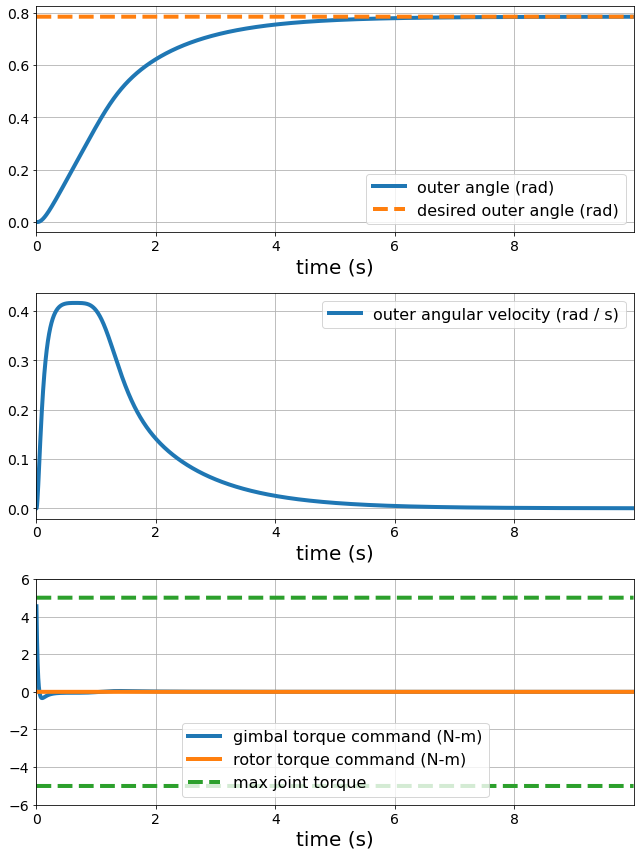

In [8]:
# Create a figure with three subplots
fig, ax = plt.subplots(3, 1, figsize=(9, 12))

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'],  np.ones_like(data['t']) * q_des, '--', label='desired outer angle (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties
for i in range(0, 3):
    ax[i].set_xlabel('time (s)', fontsize=20)
    ax[i].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()